In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json
import numpy as np
import torch
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font='serif')
sns.set_context("paper", font_scale=2.5)

In [3]:
%load_ext autoreload
%autoreload 2

from src.vae_models import CVAE
import src.utils as utils
import src.preprocess_lib as preprocess_lib
from src.preprocess_lib import *
import src.testing_lib as testing_lib

In [4]:
config_dir = '/home/kbolat/Python/behavio-temporal-vae/runs/sweep_runs_corrected/sweep_Sep13_07-57-26'
config_file = 'config.json'
save_dir = 'transfer'

with open(os.path.join(config_dir, config_file), 'r') as f: config = json.load(f)

In [5]:
trainset, valset, conditioner, user_ids, months, condition_set, X_test, X_missing, num_missing_days, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Amputation Parameters...................a=0.85, b=10
Mean of enrolments: 28.59
Number of Training Points...............1377166
Number of Testing Points................459055
Number of Validation Points.............459055
Number of Missing Points................197674
Found a matching user model in data/goi4_dp_full_Gipuzkoa/user_encoding_models/model_1


In [6]:
# Load model
model = CVAE(input_dim=valset.inputs.shape[1], conditioner=conditioner, **config["model"])
model.load(config_dir)

USING SIGMA_LIM!
USING SIGMA_LIM!


In [7]:
RANDOM_SEED = 55
np.random.seed(RANDOM_SEED)

In [8]:
missing_hours = np.random.randint(low=1, high=24, size=X_test.shape[0])

In [9]:
available_hours = 24-missing_hours
start_hours = np.random.randint(low=0, high=available_hours+1)

In [10]:
X_test_amp = X_test.copy()
for i in range(X_test.shape[0]): X_test_amp[i,start_hours[i]:start_hours[i]+missing_hours[i]] = np.nan

<BarContainer object of 24 artists>

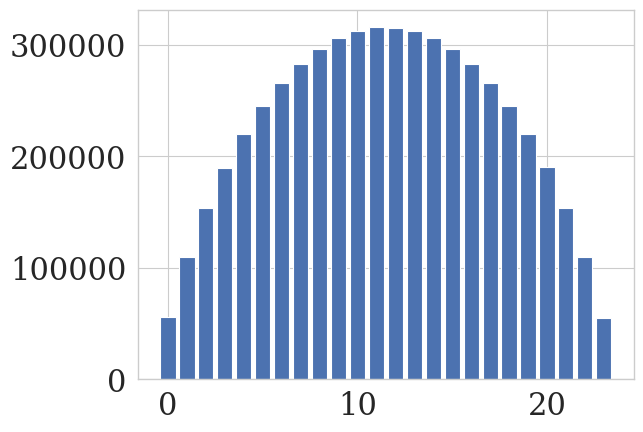

In [11]:
plt.bar(np.arange(24), np.sum(np.isnan(X_test_amp), axis=0))

In [12]:
@torch.no_grad()
def get_conditonal_params(model, param_dict, x_observed, observed_indices):
    mu = param_dict["mu"]
    Sigma = model.create_covariance_matrix(param_dict)
    
    unobserved_indices = torch.tensor([i for i in range(model.output_dim) if i not in observed_indices])
    
    mu_o = mu[:,observed_indices]
    mu_u = mu[:,unobserved_indices]

    Sigma_oo = Sigma[:,observed_indices][:,:, observed_indices]
    Sigma_ou = Sigma[:,observed_indices][:,:, unobserved_indices]
    Sigma_uu = Sigma[:,unobserved_indices][:,:, unobserved_indices]

    Sigma_oo_inv = torch.linalg.inv(Sigma_oo)
    conditional_mean = mu_u + ((x_observed - mu_o)[:,None,...] @ Sigma_oo_inv @ Sigma_ou).squeeze()
    conditional_cov = Sigma_uu - Sigma_ou.mT @ Sigma_oo_inv @ Sigma_ou
    return conditional_mean, conditional_cov

@torch.no_grad()
def sample_conditional(model, param_dict, x_observed, observed_indices, num_samples=1):

    conditional_mean, conditional_cov = get_conditonal_params(model, param_dict, x_observed, observed_indices)

    eps = torch.randn((num_samples, model.output_dim - len(observed_indices)), device=conditional_mean.device)
    L_cond = torch.linalg.cholesky(conditional_cov)
    cond_samples = conditional_mean + eps @ L_cond.mT  

    return cond_samples, conditional_mean, conditional_cov

@torch.no_grad()
def pseudo_gibbs(model, x, missing_mask, conditioner, condition_set, num_iter=100, device="cpu"):
    
    observed_indices = torch.where((~missing_mask)[0])[0]
    for _ in range(num_iter):
        conditions = torch.tensor(conditioner.transform({k: v for k, v in condition_set.items()})).float().to(device)
        x_rec, _ = model.forward(x, conditions)

        cond_sample, cond_mu, cond_cov = sample_conditional(model.decoder, {k:v[0] for k,v in x_rec["params"].items()}, x[:,observed_indices], observed_indices)
        x[missing_mask] = cond_sample

    return x, x_rec["params"]

@torch.no_grad()
def metropolis_within_gibbs(model, x, missing_mask, conditioner, condition_set, num_samples=10, num_iter=100, device="cpu"):
    
    x_samples = list()

    observed_indices = torch.where((~missing_mask)[0])[0]
    
    conditions = torch.tensor(conditioner.transform({k: v for k, v in condition_set.items()})).float().to(device)
    
    z = model.encoder.sample(model.encoder(torch.cat((x, conditions), dim=1)))[0]
    x_params = model.decoder(torch.cat((z, conditions),dim=1))

    num_accepted = 0
    for itx in range(num_iter):

        if itx%100 == 0: print(f"Iteration: {itx}")

        z_params = model.encoder(torch.cat((x, conditions), dim=1))

        x_params = model.decoder(torch.cat((z, conditions),dim=1))

        z_proposal = model.encoder.sample(model.encoder(torch.cat((x, conditions), dim=1)))[0]

        x_params_proposal = model.decoder(torch.cat((z_proposal, conditions),dim=1))

        loglikelihood_proposal = model.decoder.log_likelihood(x, param_dict=x_params_proposal) + model.encoder.log_likelihood(z_proposal, param_dict=model.prior_params) - model.encoder.log_likelihood(z_proposal, param_dict=z_params)

        loglikelihood = model.decoder.log_likelihood(x, param_dict=x_params) + model.encoder.log_likelihood(z, param_dict=model.prior_params) - model.encoder.log_likelihood(z, param_dict=z_params)

        log_ratio = loglikelihood_proposal - loglikelihood

        rho = torch.minimum(torch.tensor([1]), torch.exp(log_ratio.cpu()))

        eps = torch.rand((1,))

        # rho_idx = torch.where(eps<rho)[0]
        if eps<rho:
            z = z_proposal*1.0
            num_accepted += 1
            cond_sample, cond_mu, cond_cov = sample_conditional(model.decoder, x_params_proposal, x[:,observed_indices], observed_indices)
            x[missing_mask] = cond_sample

            x_samples.append(x[0].cpu().tolist())

            if num_accepted > num_samples: x_samples.pop(0)

        else:
            cond_sample, cond_mu, cond_cov = sample_conditional(model.decoder, x_params, x[:,observed_indices], observed_indices)
            x[missing_mask] = cond_sample

        conditions = torch.tensor(conditioner.transform({k: v for k, v in condition_set.items()})).float().to(device)

        if (itx+1)%100==0: 
            # print(f"Average log-likelihood={loglikelihood.mean().item()}")
            print(f"Acceptance ratio: %{num_accepted/itx*100}")
            # num_accepted = 0
    return np.array(x_samples), x_params, z_params


@torch.no_grad()
def cvae_imputation(model, data, conditioner, condition_set, num_samples=10, num_iter=100, warmup_steps=10, device="cpu"):
    model.to(device)
    model.prior_params = {key: value.to(device) for key, value in model.prior_params.items()}

    x = data.copy()
    x = torch.tensor(x).float().to(device)
    missing_mask = torch.isnan(x)
    x[missing_mask] = 0.0

    if warmup_steps>0:
        print("Pseudo-Gibbs warm-up is starting...")
        x, _ = pseudo_gibbs(model, x, missing_mask, conditioner, condition_set, num_iter=warmup_steps, device=device)
        print("Pseudo-Gibbs warm-up has ended.")

    print("Metropolis-within-Gibbs is starting...")
    x_samples, x_rec, z_rec = metropolis_within_gibbs(model, x, missing_mask, conditioner, condition_set, num_samples=num_samples, num_iter=num_iter, device=device)
    print("Metropolis-within-Gibbs has ended.")

    model.to("cpu")
    model.prior_params = {key: value.to("cpu") for key, value in model.prior_params.items()}

    return x_samples, {key: value.to("cpu") for key, value in x_rec.items()}, {key: value.to("cpu") for key, value in z_rec.items()}



In [13]:
data_idx = np.arange(420,421)

In [58]:
X_test_imp, x_params, z_params = cvae_imputation(model.eval(), X_test_amp[data_idx], conditioner=conditioner, condition_set={k: v[data_idx] for k, v in condition_set["test"].items()}, num_samples=100, num_iter=5000, warmup_steps=1000, device="cuda:1")

Pseudo-Gibbs warm-up is starting...
Pseudo-Gibbs warm-up has ended.
Metropolis-within-Gibbs is starting...
Iteration: 0
Acceptance ratio: %45.45454545454545
Iteration: 100
Acceptance ratio: %55.778894472361806
Iteration: 200
Acceptance ratio: %53.84615384615385
Iteration: 300
Acceptance ratio: %55.13784461152882
Iteration: 400
Acceptance ratio: %56.51302605210421
Iteration: 500
Acceptance ratio: %56.42737896494157
Iteration: 600
Acceptance ratio: %55.65092989985694
Iteration: 700
Acceptance ratio: %57.82227784730913
Iteration: 800
Acceptance ratio: %56.84093437152391
Iteration: 900
Acceptance ratio: %56.35635635635635
Iteration: 1000
Acceptance ratio: %56.86988171064604
Iteration: 1100
Acceptance ratio: %56.63052543786489
Iteration: 1200
Acceptance ratio: %56.96689761354888
Iteration: 1300
Acceptance ratio: %57.11222301644031
Iteration: 1400
Acceptance ratio: %57.238158772515014
Iteration: 1500
Acceptance ratio: %57.160725453408375
Iteration: 1600
Acceptance ratio: %57.68098881695115
I

In [59]:
observed_indices = np.where(~np.isnan(X_test_amp[data_idx])[0])[0].tolist()
unobserved_indices = [i for i in range(model.decoder.output_dim) if i not in observed_indices]

In [60]:
cond_median = np.median(X_test_imp, axis=0)
cond_upper_quartile = np.percentile(X_test_imp, 75, axis=0)
cond_lower_quartile = np.percentile(X_test_imp, 25, axis=0)

In [61]:
mvn_mu = np.mean(X_test_imp[:,unobserved_indices], axis=0)
mvn_cov = np.cov(X_test_imp[:,unobserved_indices], rowvar=0)

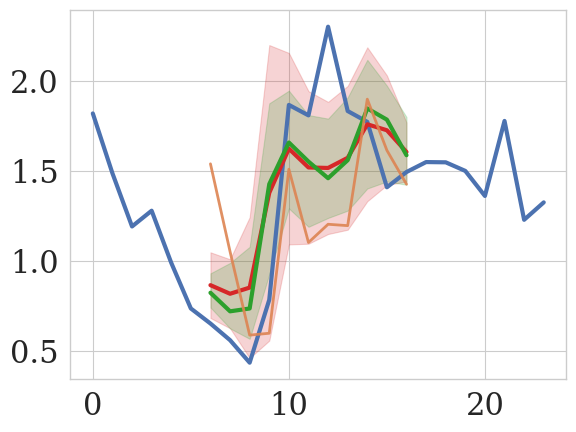

In [66]:
# plt.plot(unobserved_indices, X_test_imp[:-1, unobserved_indices].T, lw=2, alpha=0.05, label="Imputation", color="tab:orange")
plt.plot(X_test[data_idx].T, lw=3, label="Ground truth")
plt.plot(unobserved_indices, mvn_mu, lw=3, color="tab:red")
plt.fill_between(unobserved_indices, mvn_mu-2*np.diag(mvn_cov), mvn_mu+2*np.diag(mvn_cov), alpha=0.2, color="tab:red")
plt.plot(unobserved_indices, cond_median[unobserved_indices], lw=3, color="tab:green")
plt.fill_between(unobserved_indices, cond_lower_quartile[unobserved_indices], cond_upper_quartile[unobserved_indices], alpha=0.2, color="tab:green")
# plt.plot(np.where(np.isnan(X_test_amp[data_idx]))[1], cond_mu[0], lw=2, label="Imputation")
# plt.fill_between(np.where(np.isnan(X_test_amp[data_idx]))[1], cond_mu[0]-2*conditional_marg_sigma, cond_mu[0]+2*conditional_marg_sigma, alpha=0.2)
plt.plot(np.where(np.isnan(X_test_amp[data_idx]))[1], X_test_imp[0,unobserved_indices].T, lw=2, label="Imputation", alpha=0.9)

# plt.plot( x_params["mu"][0], lw=2, label="Imputation")
plt.show()

In [63]:
#normality test
import pingouin as pg
pg.multivariate_normality(X_test_imp[:,unobserved_indices], alpha=0.05)

HZResults(hz=1.0069437589387098, pval=0.00533934607864983, normal=False)

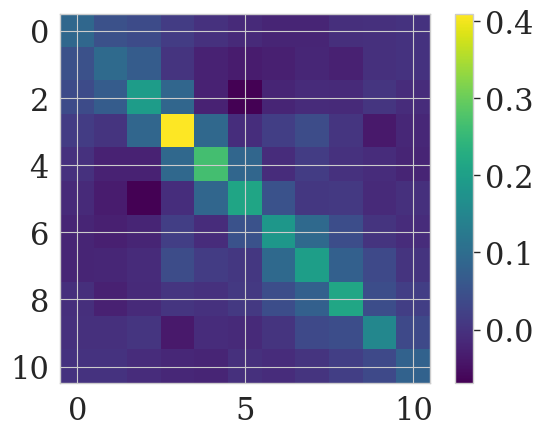

In [64]:
plt.imshow(mvn_cov, cmap="viridis")
plt.colorbar()

In [90]:
x_rec, _ = model.reconstruct(torch.tensor(X_test[data_idx]).float(), torch.tensor(conditioner.transform({k: v[data_idx] for k, v in condition_set["test"].items()})).float())

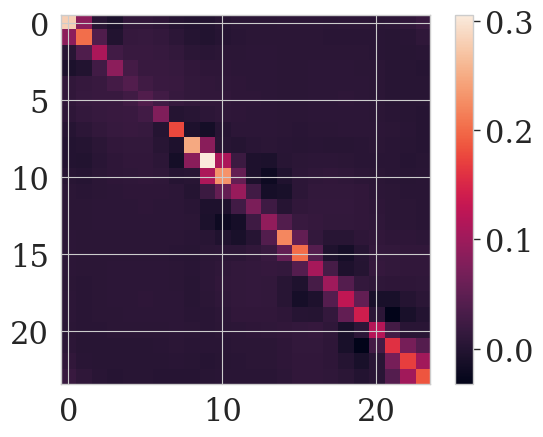

In [91]:
plt.imshow(model.decoder.create_covariance_matrix(x_params)[0].detach())
plt.colorbar()

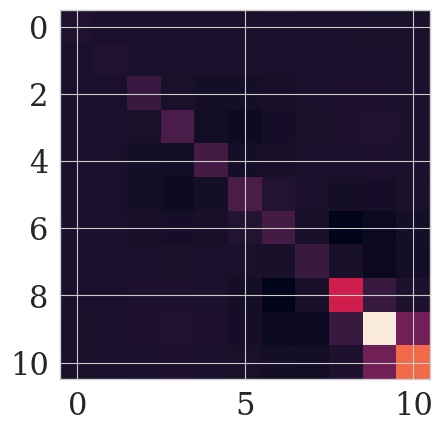

In [73]:
plt.imshow(cond_cov[0])

In [29]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [43]:
imputer = IterativeImputer(random_state=RANDOM_SEED, verbose=True)

In [41]:
X_train = trainset.inputs
X_train.shape

(1377166, 24)

In [44]:
imputer.fit(np.concatenate((X_train, X_test_amp)))

[IterativeImputer] Completing matrix with shape (1836221, 24)
[IterativeImputer] Change: 19.64632811735178, scaled tolerance: 0.005610138716376447 
[IterativeImputer] Change: 9.43672140457743, scaled tolerance: 0.005610138716376447 
[IterativeImputer] Change: 6.479051604364493, scaled tolerance: 0.005610138716376447 
[IterativeImputer] Change: 4.9972395110187025, scaled tolerance: 0.005610138716376447 
[IterativeImputer] Change: 4.119554789099921, scaled tolerance: 0.005610138716376447 
[IterativeImputer] Change: 3.4227325236295294, scaled tolerance: 0.005610138716376447 
[IterativeImputer] Change: 2.967913571122221, scaled tolerance: 0.005610138716376447 
[IterativeImputer] Change: 2.64452409719331, scaled tolerance: 0.005610138716376447 
[IterativeImputer] Change: 2.358013223997091, scaled tolerance: 0.005610138716376447 
[IterativeImputer] Change: 2.103819058045188, scaled tolerance: 0.005610138716376447 


/home/kbolat/.conda/envs/torchenv/lib/python3.9/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


IterativeImputer(random_state=2112, verbose=True)

In [77]:
imputer.transform(X_test_amp[data_idx])

[IterativeImputer] Completing matrix with shape (1, 24)


array([[1.89224602, 2.15006027, 2.2484636 , 2.28853307, 2.16586513,
        2.14283909, 2.10439965, 2.04427232, 2.0395811 , 2.24948194,
        2.45372076, 2.49164174, 2.52472281, 2.54446121, 2.58474445,
        2.7963431 , 3.11060457, 2.52594856, 2.57478987, 2.2627047 ,
        1.84476711, 1.73149431, 1.63608321, 1.80202559]])

[IterativeImputer] Completing matrix with shape (1, 24)


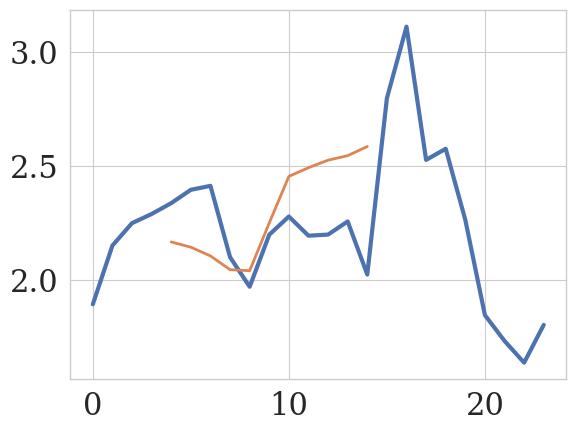

In [78]:
plt.plot(X_test[data_idx].T, lw=3, label="Ground truth")
plt.plot(np.where(np.isnan(X_test_amp[data_idx]))[1], (imputer.transform(X_test_amp[data_idx])[np.isnan(X_test_amp[data_idx])]), lw=2, label="Imputation")